In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.cm as cm
#import geopandas as gpd
import wbgapi as wb
#import dill
import pathlib
from autumn.settings import INPUT_DATA_PATH
from autumn.core.project import get_project
from autumn.core.inputs.social_mixing.queries import get_prem_mixing_matrices

In [57]:
plt.style.use("ggplot")

In [43]:
#get data from Worldbank data by API
kir_tb = wb.data.DataFrame(['SH.TBS.CURE.ZS', 'SH.TBS.DTEC.ZS', 'SH.TBS.INCD'], 'KIR', mrv = 20)
series_name = {'SH.TBS.CURE.ZS':'Tuberculosis treatment success rate (% of new cases)',
                'SH.TBS.DTEC.ZS': 'Tuberculosis case detection rate (%, all forms)',
                'SH.TBS.INCD': 'Incidence of tuberculosis (per 100,000 people)'
            }
kir_tb.reset_index(inplace=True)
kir_tb.replace({'series':series_name}, inplace = True)
df = pd.melt(kir_tb, id_vars='series')
df.rename(columns={'variable':'Year'}, inplace = True)
df['Year'] = df['Year'].str[2:].astype(int)
df.reset_index(drop = True, inplace=True)
p = pathlib.PurePath(INPUT_DATA_PATH, 'tb_kir', "bcg.csv")
bcg = pd.melt(pd.read_csv(p), id_vars="Year")
bcg.rename(columns={'variable':'series'}, inplace = True)
newdf = pd.concat([df, bcg], ignore_index=True)
newdf.index = pd.to_datetime(newdf['Year'], format = "%Y")
df = newdf
del newdf
del bcg

## Notifications, Case detection and Treatment success of Kiribati from 2000 - 2020

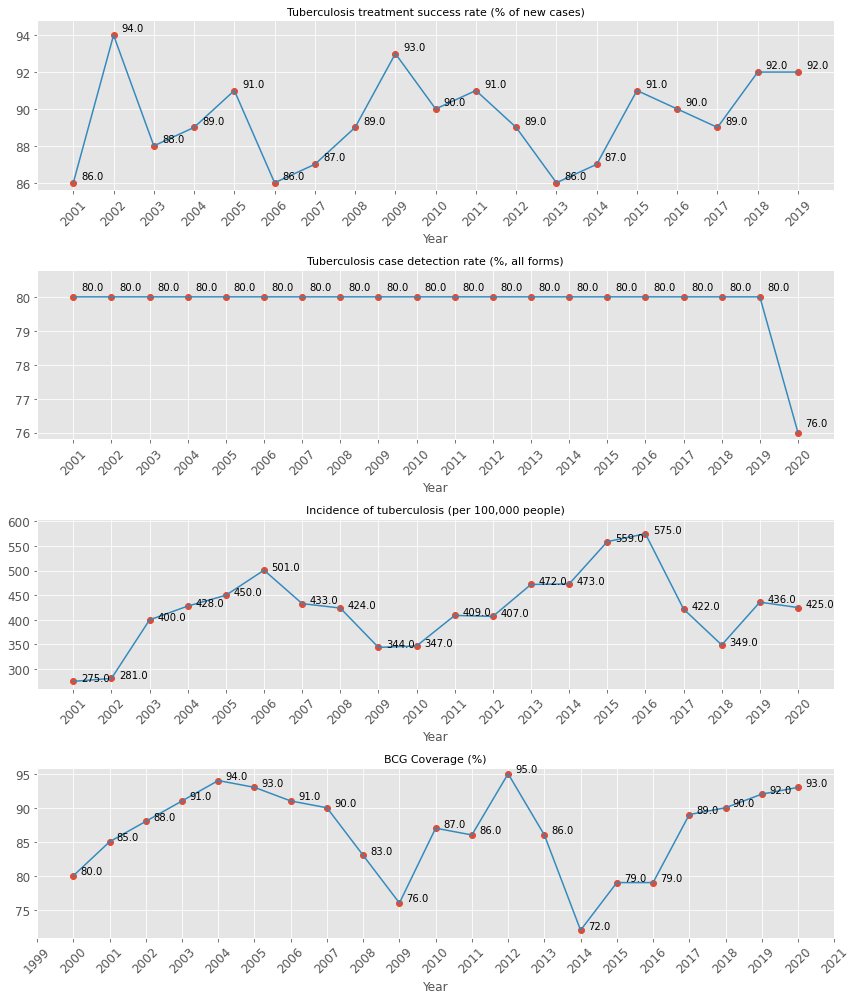

In [59]:
indi = df['series'].unique().tolist()
fig, ax = plt.subplots(nrows=len(indi), figsize=(12,len(indi)*3.5))
loc = plticker.MultipleLocator(base=1)
for i in indi:
    idx = indi.index(i)
    filt = df['series'] == i
    ax[idx].plot(df.loc[filt]['Year'],df.loc[filt]['value'], 'o')
    ax[idx].plot(df.loc[filt]['Year'],df.loc[filt]['value'])
    ax[idx].set_title(i, size=11) #here I am setting the title of each subplot to be the category
    ax[idx].set_xlabel('Year', size=12) #setting the ylabel and font size
    
    for j, val in enumerate(df.loc[filt]['value'].to_list()):
        if not np.isnan(val):
            ax[idx].text(df.loc[filt]['Year'].to_list()[j]  + .2, df.loc[filt]['value'].to_list()[j] + .2, str(val))
    if i == series_name['SH.TBS.INCD']:
        ax[idx].set_ylim(top = max(df.loc[filt]['value']) + 30)
    else:
        ax[idx].set_ylim(top = max(df.loc[filt]['value']) + 0.8)
    ax[idx].xaxis.set_major_locator(loc)
    ax[idx].xaxis.set_tick_params(labelsize=12, labelrotation = 45) #setting the font size of the x axis
    ax[idx].yaxis.set_tick_params(labelsize=12)
plt.tight_layout()

## Age distribution of Kiribati population in 2020

In [60]:
dist = pd.read_csv(pathlib.PurePath(INPUT_DATA_PATH, 'tb_kir', "dist.csv"))
dist['age_bin'] = pd.to_numeric(dist['age_bin'])
dist.sort_values(by=['age_bin'], inplace=True)

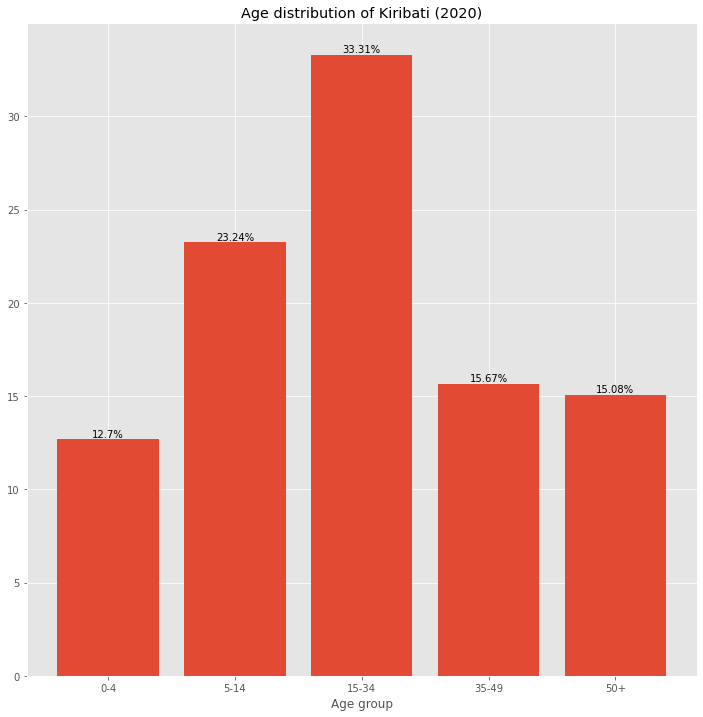

In [61]:
fig = plt.figure(figsize = (12, 12))
plt.bar(dist['age_group'], dist['value'])
for i in range(len(dist['value'])):
    plt.annotate(str(dist['value'][i]) + '%', xy=(dist['age_group'][i],dist['value'][i]), ha='center', va='bottom')
plt.xlabel('Age group', size = 12)
plt.title('Age distribution of Kiribati (2020)')
plt.show()

## Mixing matrix

In [50]:
project = get_project("tuberculosis","kiribati")

In [51]:
base_params = project.param_set.baseline

In [52]:
mixing_matrix = get_prem_mixing_matrices('KIR', base_params['age_breakpoints'], None)

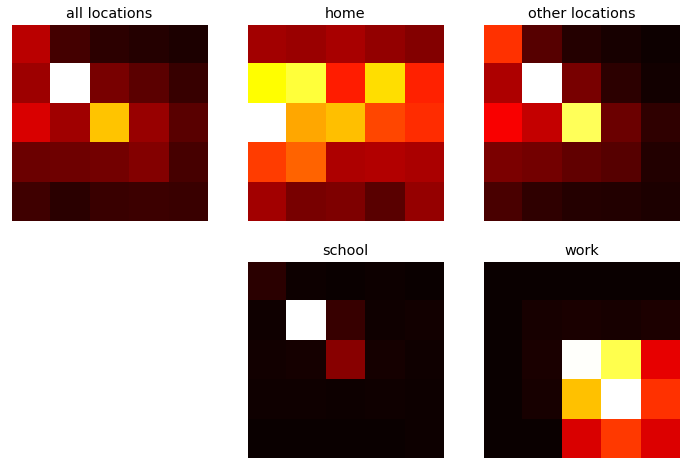

In [58]:
fig = plt.figure(figsize=(12, 8))
positions = [1, 2, 3, 5, 6]
for i_loc, location in zip(positions, mixing_matrix.keys()):
    ax = fig.add_subplot(2, 3, i_loc)
    ax.imshow(
        np.flipud(np.transpose(mixing_matrix[location])), 
        cmap=cm.hot, 
        vmin=0,
        vmax=mixing_matrix[location].max(), 
        origin="lower"
    )
    ax.set_title(location.replace("_", " "))
    ax.set_xticks([])
    ax.set_yticks([])